In [2]:
from scipy.stats import lognorm, describe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
RAI_SHAPE = 3
eth0 = lognorm.rvs(1, loc = 100, size = 1)
rai0 = lognorm.rvs(1, loc = 1, size = 1)

In [4]:
ae = 0.3; be = 0; ce = 1
ar = 0.99; br = 0; cr = 1

In [5]:
sample_size = 10000

In [6]:
eth = np.zeros(sample_size+1)
rai = np.zeros(sample_size+1)
eth[0] = eth0
rai[0] = rai0
print('Starting ETH: ', eth[0], '; starting RAI: ', rai[0])

Starting ETH:  102.86125194411294 ; starting RAI:  2.5746533832339606


In [7]:
for t in range(1,sample_size+1):
    eth[t] = ae*eth[t-1] + be + ce*lognorm.rvs(1, loc = 100, size = 1)
    rai[t] = ar*rai[t-1] + br + cr*lognorm.rvs(RAI_SHAPE, loc = 1, size = 1)
price = eth/rai

Text(0, 0.5, 'RAI Balance')

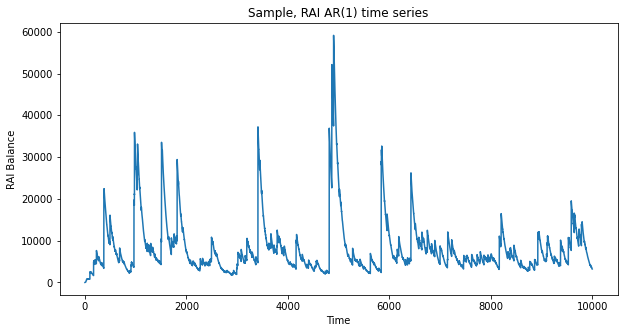

In [8]:
plt.figure(figsize=(10,5))
plt.plot(rai)
plt.title('Sample, RAI AR(1) time series')
plt.xlabel('Time')
plt.ylabel('RAI Balance')

Text(0, 0.5, 'ETH Balance')

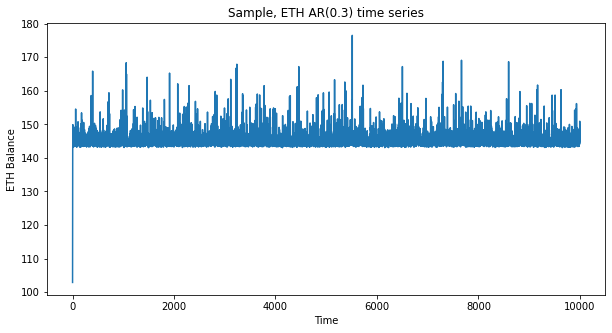

In [9]:
plt.figure(figsize=(10,5))
plt.plot(eth)
plt.title('Sample, ETH AR(0.3) time series')
plt.xlabel('Time')
plt.ylabel('ETH Balance')

Text(0, 0.5, 'Price (ETH/RAI)')

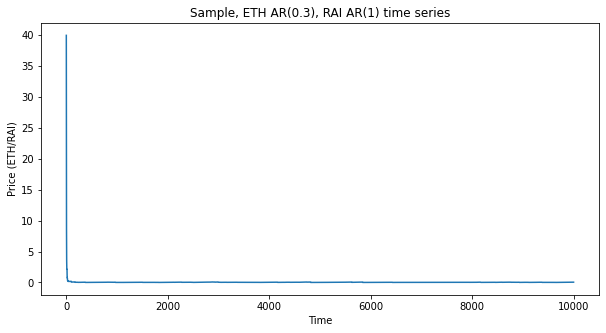

In [10]:
plt.figure(figsize=(10,5))
plt.plot(price)
plt.title('Sample, ETH AR(0.3), RAI AR(1) time series')
plt.xlabel('Time')
plt.ylabel('Price (ETH/RAI)')

In [11]:
pct_chg_price = (price[1:] - price[0:-1])/ price[0:-1]
pct_chg_rai = (rai[1:] - rai[0:-1])/ rai[0:-1]

Text(0, 0.5, '% Change')

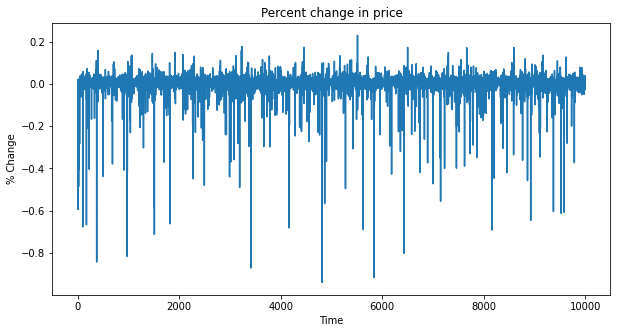

In [12]:
plt.figure(figsize=(10,5))
plt.plot(pct_chg_price)
plt.title('Percent change in price')
plt.xlabel('Time')
plt.ylabel('% Change')

In [13]:
pct_df = pd.DataFrame(pct_chg_price)
abspct_df = pd.DataFrame(abs(pct_chg_price))

In [14]:
b = abspct_df.describe([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.90])

In [20]:
b

,0
count,10000.000000
mean,0.019210
std,0.046942
min,0.000001
10%,0.001981
20%,0.004036
30%,0.006043
40%,0.007859
50%,0.009768
60%,0.012131


In [19]:
b.loc['90%'][0]

0.034024590129679295

Once the 90% value for each run is stored, the mean value can be computed across MC runs for each parameter subset. For those runs which **fail**, the resulting value is a _proxy_ for an unknown random variable indicating the maximum value we would want an absolute price change to have, before shutting down the controller. By averaging across subsets, we get a single number that we could call the _critical liquidity threshold_. 

Ideally, we would want stable systems to have low 90% values, making them more likely to remain below the critical liquidity threshold. So our system goal is to ensure that 'good' parameter values have stable systems with a low 90% value.

A future experiment would do the following:
1. Select a subset where most (or all) runs failed the stability criteria when the controller was _on_, but was stable when the controller was _off_.
2. For that subset, start with the controller on and run until the mean 90% value of the absolute price change is exceeded. Then shut off the controller and see whether (and e.g. how long etc.) the system recovers stability.
3. For that subset, start with the controller on and run until the mean 90% value of the absolute price change is exceeded. Then do nothing and see how long until the system exhibits instability (of the type seen in step 1). This shows how long it takes for the system to manifest the 'trouble ahead' predicted by that mean 90% value prediction. 